In [1]:
from glob import glob

import joblib

from joblib import parallel_backend
import numpy as np
import pandas as pd

import tensorflow as tf
import keras.layers
from attention import Attention
import gc

import warnings

warnings.filterwarnings("ignore")

2024-03-26 22:36:06.471301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Make Predictions

In [2]:
def scale_input(input_arr, X_scaler):
    num_data, time_lag, num_features = input_arr.shape
    input_arr = input_arr.reshape(num_data * time_lag, num_features)

    with parallel_backend('threading', n_jobs=12):
        scaled_arr = X_scaler.transform(input_arr)
        # Mask NaN for (-1)
        scaled_arr[np.isnan(scaled_arr)] = -1

    scaled_arr = scaled_arr.reshape(num_data, time_lag, num_features)

    return scaled_arr


def model_predict(input_arr, num_model,
                  n_lag, n_features,
                  X_scaler, y_scaler):
    """
    :param input_arr:
    :param region:
    :param num_model:
    :param n_lag:
    :param n_features:
    :return:
    """
    # Scale input array
    scaled_arr = scale_input(input_arr, X_scaler)

    tensor = tf.convert_to_tensor(scaled_arr,
                                  dtype=tf.float32)

    for i, num_M in enumerate(num_model):
        model_path = f'../model/LSTM_model/knn/LSTM_{num_M}.h5'
        # Load model
        model = keras.models.load_model(model_path,
                                        custom_objects={'Attention': Attention},
                                        compile=True)

        # Make Prediction
        predict = model.predict(tensor, batch_size=128)

        # Clear Session to Free memory
        del model
        tf.keras.backend.clear_session()
        tf.compat.v1.reset_default_graph()
        _ = gc.collect()

        with parallel_backend('threading', n_jobs=10):
            inv_predict = y_scaler.inverse_transform(predict)

        print(f'Min value of prediction: {np.nanmin(inv_predict)}')
        print(f'Max value of prediction: {np.nanmax(inv_predict)}')
        print(f'Num of values < 0: {inv_predict[inv_predict < 0].shape}')
        print(f'Num of values > 50: {inv_predict[inv_predict > 50].shape}')
        inv_predict[inv_predict < 0] = 0.5

        if i == 0:
            pred_models = inv_predict
        else:
            pred_models = np.hstack((pred_models, inv_predict))

        # Release GPU Memory
        # device = cuda.get_current_device()
        # device.reset()

    return pred_models

In [3]:
year = 2005
test_X_path = sorted(glob(f"../data/input_TS/TS_X_{year}-*.npy"))
test_y_path = sorted(glob(f"../data/input_TS/TS_y_{year}-*.npy"))

print(f"Num. of Days of Training Set: {len(test_X_path)}")

test_X = np.concatenate([np.load(daily_X_path) for daily_X_path in test_X_path])
test_y = np.concatenate([np.load(daily_y_path) for daily_y_path in test_y_path])
test_date = np.concatenate([np.full(np.load(daily_y_path).shape, daily_y_path.split("_")[-1].split(".")[0]) 
                           for daily_y_path in test_y_path])

# Remove knnidw_val and knn_distance
mask = list(range(0, 23))
mask.remove(15)
mask.remove(17)
test_X = test_X[:, :, mask]

print(f"Num. of data: {test_X.shape}")
# Only keep non-negative records
test_X = test_X[(test_y > 0).squeeze(), :, :]
test_date = test_date[(test_y > 0).squeeze(), :]
test_y = test_y[(test_y > 0).squeeze(), :]

# Keep records without NaNs
# nonan_idx = np.argwhere(~np.isnan(test_X).any(axis=(1, 2))).squeeze()
# test_X = test_X[nonan_idx, :, :]
# test_y = test_y[nonan_idx, :]
# test_date = test_date[nonan_idx, :]
print(f"Num. of data: {test_X.shape}")

test_lat = test_X[:, -1, 5]
test_lon = test_X[:, -1, 6]

Num. of Days of Training Set: 129
Num. of data: (46581, 21, 21)
Num. of data: (46573, 21, 21)


In [ ]:
# Load Scaler
X_scaler = joblib.load("../model/LSTM_Scaler/X_scaler.pkl")
y_scaler = joblib.load("../model/LSTM_Scaler/y_scaler.pkl")

# Make predictions
num_model = list(range(1,11))
n_lag = test_X.shape[1]
n_features = test_X.shape[2]

preds = model_predict(input_arr=test_X, num_model=num_model, 
                      n_lag=n_lag, n_features=n_features,
                      X_scaler=X_scaler, y_scaler=y_scaler)

eval_df = pd.DataFrame({
    'lat': test_lat.squeeze(),
    'lon': test_lon.squeeze(),
    'date': test_date.squeeze(),
    'truth_pm25': test_y.squeeze(),
})

for i in num_model:
    eval_df[f'model_{i}_pm25'] = preds[:, i-1].squeeze()
    
eval_df.to_csv(f"../eval/LSTM_Eval_{year}.csv", index=False)

2024-03-26 22:35:33.221079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 22:35:33.262969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 22:35:33.263364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-26 22:35:33.264238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

  28/2102 [..............................] - ETA: 12s  

2024-03-26 22:35:41.897837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2102/2102 [==============================] - 16s 5ms/step
Min value of prediction: 0.7650032043457031
Max value of prediction: 300.69366455078125
Num of values < 0: (0,)
Num of values > 50: (805,)


In [ ]:
eval_df

# 2. Evaluation

In [4]:
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

from scipy.special import kl_div, rel_entr

In [5]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def kl_divergence(I: np.ndarray, J: np.ndarray):
    def probability_dist(I):
        return (
            np.histogramdd(np.ravel(I), bins=I.size // 2)[0] / I.size
        )
    
    epsilon = 1e-10
    P = probability_dist(I) + epsilon
    Q = probability_dist(J) + epsilon
    
    return np.where(P != 0, P * np.log2(P / Q), 0).sum()

In [ ]:
year = 2005
model_num = 9
pred_df = pd.read_csv(f'../eval/LSTM_Eval_{year}.csv')

high_df = pred_df[pred_df['truth_pm25'] >= 35]

print(f"All Records: {pred_df.shape}")
print(f"All RMSE: {mean_squared_error(pred_df['truth_pm25'], pred_df[f'model_{model_num}_pm25'], squared=False)}")
print(f"All MBE: {np.mean(pred_df[f'model_{model_num}_pm25'] - pred_df['truth_pm25'])}")
print(f"All KL Div: {KL(pred_df['truth_pm25'], pred_df[f'model_{model_num}_pm25'])}")

print(f"ST-High Records: {high_df.shape}")
print(f"ST-High RMSE: {mean_squared_error(high_df['truth_pm25'], high_df[f'model_{model_num}_pm25'], squared=False)}")
print(f"ST-High MBE: {np.mean(high_df[f'model_{model_num}_pm25'] - high_df['truth_pm25'])}")
print(f"ST-High KL Div: {KL(high_df['truth_pm25'], high_df[f'model_{model_num}_pm25'])}")

In [36]:
year = 2018
model_num = [1, 5, 9]
pred_df = pd.read_csv(f'../eval/LSTM_Eval_{year}.csv')
col = [f'model_{num}_pm25' for num in model_num]
pred_df['ensemble_pm25'] = pred_df[col].mean(axis=1)

high_df = pred_df[pred_df['truth_pm25'] >= 35]

print(f"All Records: {pred_df.shape}")
print(f"All RMSE: {mean_squared_error(pred_df['truth_pm25'], pred_df['ensemble_pm25'], squared=False)}")
print(f"All MBE: {np.mean(pred_df['ensemble_pm25'] - pred_df['truth_pm25'])}")
print(f"All KL Div: {kl_divergence(pred_df['truth_pm25'], pred_df['ensemble_pm25'])}")

print(f"ST-High Records: {high_df.shape}")
print(f"ST-High RMSE: {mean_squared_error(high_df['truth_pm25'], high_df['ensemble_pm25'], squared=False)}")
print(f"ST-High MBE: {np.mean(high_df['ensemble_pm25'] - high_df['truth_pm25'])}")
print(f"ST-High KL Div: {kl_divergence(high_df['truth_pm25'], high_df['ensemble_pm25'])}")

All Records: (234189, 15)
All RMSE: 2.6569341933781683
All MBE: 0.2319218938294141
All KL Div: 5.516027218232366
ST-High Records: (1626, 15)
ST-High RMSE: 20.12064046672085
ST-High MBE: -2.284605621381713
ST-High KL Div: 4.283537005917137


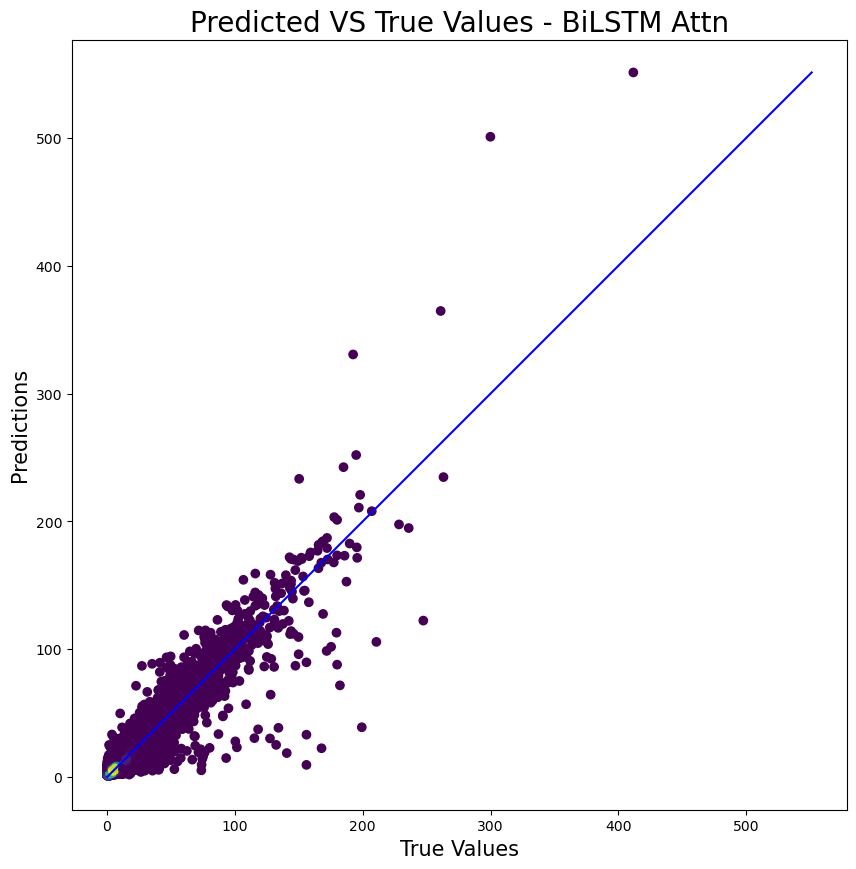

In [37]:
## Viz Scatter
plt.figure(figsize=(10, 10))
xy = np.vstack([pred_df['truth_pm25'], pred_df['ensemble_pm25']])
z = gaussian_kde(xy)(xy)
plt.scatter(pred_df['truth_pm25'], pred_df['ensemble_pm25'], c=z)
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(pred_df['truth_pm25']), max(pred_df['ensemble_pm25']))
p2 = min(min(pred_df['truth_pm25']), min(pred_df['ensemble_pm25']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)

plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Predicted VS True Values - BiLSTM Attn', fontsize=20)

plt.savefig(f"../eval/our_img/our_pred_truth_{year}.png")